# Определение перспективного тарифа для телеком-компании

Клиентам компании «Мегалайн» предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо проанализировать тарифы на небольшой выборке клиентов, а именно 500 пользователей, и сделать вывод — какой тариф лучше.

# Описание тарифов

**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st

Откроем файлы с данными и изучим общую информацию:

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
for data in [calls, internet, messages, tariffs, users]: print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0

In [4]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [5]:
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [6]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Необходимо заменить тип данных в столбцах с датой. Значения минут разговора округлить в большую сторону, а значения в колонках `mb_used` и `mb_per_month_included` перевести в гигабайты, поскольку тарифы считаются по минутам и гигабайтам.

## Подготовка данных

Заменим тип данных в столбцах с датой на `datetime`.

In [7]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Округлим значения минут разговора в большую сторону.

In [8]:
calls['duration'] = calls['duration'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

internet

,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000
...,...,...,...,...
149391,1499_152,319.0,2018-10-03,1499
149392,1499_153,491.0,2018-12-14,1499
149393,1499_154,0.0,2018-10-27,1499
149394,1499_155,1247.0,2018-11-26,1499


Найдем для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

Для начала добавим столбцы со значением месяца в таблицу со звонками, сообщениями и интернетом:

In [9]:
calls['call_date'].agg(['min', 'max'])

min   2018-01-01
max   2018-12-31
Name: call_date, dtype: datetime64[ns]

In [10]:
month = pd.DataFrame(pd.date_range('2018-01-01', '2018-12-31', freq='MS'))

In [11]:
month.columns = ['month']

In [12]:
users['key'] = 1
month['key'] = 1

In [13]:
template = users.merge(month,on='key')

In [14]:
# посмотрим, что получилось на примере одного пользователя

template[template['user_id'] == 1000]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,key,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-01-01
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-02-01
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-03-01
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-04-01
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-05-01
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-06-01
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-07-01
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-08-01
8,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-09-01
9,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-10-01


Абонент зарегистрировался лишь в мае, избавимся от ненужных строк.

In [15]:
template['reg_month'] = template['reg_date'].to_numpy().astype('datetime64[M]')

In [16]:
template = template[template['month'] >= template['reg_month']]

In [17]:
template[template['user_id'] == 1000]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,key,month,reg_month
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-05-01,2018-05-01
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-06-01,2018-05-01
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-07-01,2018-05-01
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-08-01,2018-05-01
8,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-09-01,2018-05-01
9,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-10-01,2018-05-01
10,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-11-01,2018-05-01
11,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,2018-12-01,2018-05-01


Добавим в таблицу информацию о длительности звонков.

In [18]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499
202603,1499_216,2018-10-18,19.0,1499
202604,1499_217,2018-11-10,11.0,1499
202605,1499_218,2018-10-06,5.0,1499


In [19]:
calls['month'] = calls['call_date'].to_numpy().astype('datetime64[M]')

In [20]:
calls_agg = calls.groupby(['month', 'user_id'])['duration'].sum().to_frame().reset_index()

calls_agg

,month,user_id,duration
0,2018-01-01,1005,95.0
1,2018-01-01,1032,380.0
2,2018-01-01,1045,9.0
3,2018-01-01,1055,551.0
4,2018-01-01,1071,194.0
...,...,...,...
3169,2018-12-01,1494,418.0
3170,2018-12-01,1495,1031.0
3171,2018-12-01,1496,518.0
3172,2018-12-01,1497,545.0


Добавим информацию о количестве звонков.

In [21]:
sum_calls_agg = calls.groupby(['month', 'user_id'])['id'].count().to_frame().reset_index()

sum_calls_agg

,month,user_id,id
0,2018-01-01,1005,15
1,2018-01-01,1032,61
2,2018-01-01,1045,1
3,2018-01-01,1055,64
4,2018-01-01,1071,24
...,...,...,...
3169,2018-12-01,1494,62
3170,2018-12-01,1495,155
3171,2018-12-01,1496,80
3172,2018-12-01,1497,71


In [22]:
user_info = calls_agg.merge(sum_calls_agg, how='outer', on=['month', 'user_id'])
user_info = user_info.rename(columns={'id': 'calls'})

user_info[user_info['user_id'] == 1498]

,month,user_id,duration,calls
1141,2018-07-01,1498,175.0,23
1478,2018-08-01,1498,400.0,57
1847,2018-09-01,1498,471.0,59
2258,2018-10-01,1498,247.0,41


Добавим в таблицу столбец с количеством сообщений.

In [23]:
messages['month'] = messages['message_date'].to_numpy().astype('datetime64[M]')

In [24]:
messages_agg = messages.groupby(['month', 'user_id'])['id'].count().to_frame().reset_index()

messages_agg

,month,user_id,id
0,2018-01-01,1005,7
1,2018-01-01,1032,38
2,2018-01-01,1045,5
3,2018-01-01,1055,30
4,2018-01-01,1071,16
...,...,...,...
2712,2018-12-01,1493,78
2713,2018-12-01,1495,84
2714,2018-12-01,1496,51
2715,2018-12-01,1497,17


In [25]:
user_info = user_info.merge(messages_agg, how='outer', on=['month', 'user_id'])
user_info = user_info.rename(columns={'id': 'messages'})

user_info

,month,user_id,duration,calls,messages
0,2018-01-01,1005,95.0,15.0,7.0
1,2018-01-01,1032,380.0,61.0,38.0
2,2018-01-01,1045,9.0,1.0,5.0
3,2018-01-01,1055,551.0,64.0,30.0
4,2018-01-01,1071,194.0,24.0,16.0
...,...,...,...,...,...
3208,2018-12-01,1106,NaN,NaN,24.0
3209,2018-12-01,1231,NaN,NaN,191.0
3210,2018-12-01,1328,NaN,NaN,7.0
3211,2018-12-01,1473,NaN,NaN,20.0


И, наконец, столбец с использованным интернет-трафиком.

In [26]:
internet['month'] = internet['session_date'].to_numpy().astype('datetime64[M]')

In [27]:
internet_agg = internet.groupby(['month', 'user_id'])['mb_used'].sum().to_frame().reset_index()

internet_agg

,month,user_id,mb_used
0,2018-01-01,1005,2730.0
1,2018-01-01,1032,24147.0
2,2018-01-01,1045,2348.0
3,2018-01-01,1055,17111.0
4,2018-01-01,1071,15622.0
...,...,...,...
3198,2018-12-01,1494,17645.0
3199,2018-12-01,1495,23450.0
3200,2018-12-01,1496,20757.0
3201,2018-12-01,1497,19940.0


In [28]:
user_info = user_info.merge(internet_agg, how='outer', on=['month', 'user_id'])

user_info

,month,user_id,duration,calls,messages,mb_used
0,2018-01-01,1005,95.0,15.0,7.0,2730.0
1,2018-01-01,1032,380.0,61.0,38.0,24147.0
2,2018-01-01,1045,9.0,1.0,5.0,2348.0
3,2018-01-01,1055,551.0,64.0,30.0,17111.0
4,2018-01-01,1071,194.0,24.0,16.0,15622.0
...,...,...,...,...,...,...
3209,2018-12-01,1231,NaN,NaN,191.0,32481.0
3210,2018-12-01,1328,NaN,NaN,7.0,39461.0
3211,2018-12-01,1473,NaN,NaN,20.0,18432.0
3212,2018-12-01,1489,NaN,NaN,35.0,17341.0


In [29]:
user_info = user_info.merge(template, how='left', on=['month', 'user_id'])

user_info

,month,user_id,duration,calls,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,key,reg_month
0,2018-01-01,1005,95.0,15.0,7.0,2730.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1,2018-01-01
1,2018-01-01,1032,380.0,61.0,38.0,24147.0,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,1,2018-01-01
2,2018-01-01,1045,9.0,1.0,5.0,2348.0,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,1,2018-01-01
3,2018-01-01,1055,551.0,64.0,30.0,17111.0,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,1,2018-01-01
4,2018-01-01,1071,194.0,24.0,16.0,15622.0,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,1,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,2018-12-01,1231,NaN,NaN,191.0,32481.0,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,1,2018-05-01
3210,2018-12-01,1328,NaN,NaN,7.0,39461.0,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,1,2018-10-01
3211,2018-12-01,1473,NaN,NaN,20.0,18432.0,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1,2018-08-01
3212,2018-12-01,1489,NaN,NaN,35.0,17341.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,1,2018-08-01


In [30]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Переходим к помесячной выручке

In [31]:
# пропущенные значения заменяем на нули

user_info.loc[user_info['duration'].isna(), 'duration'] = 0
user_info.loc[user_info['messages'].isna(), 'messages'] = 0
user_info.loc[user_info['mb_used'].isna(), 'mb_used'] = 0

In [32]:
# функция подсчета выручки с каждого пользователя в месяц

def det_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   tariffs.loc[0, 'rub_per_gb'] * np.ceil(extra_mb / 1024) + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   tariffs.loc[1, 'rub_per_gb'] * np.ceil(extra_mb / 1024) + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

user_info['revenue'] = user_info.apply(det_revenue, axis=1)
user_info.head(10)

,month,user_id,duration,calls,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,key,reg_month,revenue
0,2018-01-01,1005,95.0,15.0,7.0,2730.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1,2018-01-01,550.0
1,2018-01-01,1032,380.0,61.0,38.0,24147.0,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,1,2018-01-01,2350.0
2,2018-01-01,1045,9.0,1.0,5.0,2348.0,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,1,2018-01-01,550.0
3,2018-01-01,1055,551.0,64.0,30.0,17111.0,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,1,2018-01-01,1103.0
4,2018-01-01,1071,194.0,24.0,16.0,15622.0,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,1,2018-01-01,750.0
5,2018-01-01,1113,110.0,18.0,14.0,767.0,52,NaT,Чита,Харитон,Булгаков,2018-01-24,smart,1,2018-01-01,550.0
6,2018-01-01,1120,55.0,5.0,0.0,657.0,25,NaT,Краснодар,Агнесса,Абдулина,2018-01-24,ultra,1,2018-01-01,1950.0
7,2018-01-01,1126,272.0,35.0,4.0,16377.0,71,NaT,Санкт-Петербург,Яна,Арсенкова,2018-01-19,ultra,1,2018-01-01,1950.0
8,2018-01-01,1134,332.0,42.0,32.0,10215.0,65,NaT,Красноярск,Марьяна,Авросимова,2018-01-16,smart,1,2018-01-01,550.0
9,2018-01-01,1135,90.0,9.0,1.0,1601.0,64,NaT,Архангельск,Милена,Воронина,2018-01-29,smart,1,2018-01-01,550.0


Получили таблицу с помесячной информацией о поведении пользователей: количестве и длительности совершенных звонков, отправленных сообщениях и потраченном интернет-трафике. Вычислили и добавили в таблицу помесячную выручку с каждого пользователя.

## Анализ данных

По каждому тарифу посчитаем медианное значение, дисперсию и стандартное отклонение. 

In [34]:
user_info.dropna(subset=['duration'], inplace=True)
tariffs_comparison = user_info.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.mean, np.median, np.var, np.std], 
                             'mb_used': [np.mean, np.median, np.var, np.std], 
                             'messages': [np.mean, np.median, np.var, np.std]})
tariffs_comparison

duration                                         mb_used           \
              mean median         std            var          mean   median   
tariff                                                                        
smart   417.934948  422.0  190.313730   36219.315784  16229.188425  16531.0   
ultra   526.623350  518.0  317.606098  100873.633397  19486.901523  19324.0   

                                     messages                                 
                 std           var       mean median        std          var  
tariff                                                                        
smart    5877.576978  3.454591e+07  33.384029   28.0  28.227876   796.812958  
ultra   10096.317202  1.019356e+08  49.363452   38.0  47.804457  2285.266143

Как мы видим, дисперсия тарифа «Ультра» превышает дисперсию тарифа «Смарт» по всем параметрам, аналогичная ситуация наблюдается и в отношении стандартного отклонения. 
Что касается медианного значения - по длительности звонков и количеству отправленных сообщений на тарифе «Ультра» оно выше, однако средний объем использованного интернет-трафика больше на тарифе «Смарт».

Построим гистограммы:

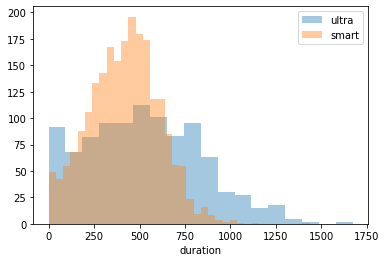

In [36]:
for tariff in ['ultra', 'smart']:
    sns.distplot(user_info.query('tariff == @tariff')['duration'], kde=False, label=tariff)
    plt.legend(['ultra', 'smart'])

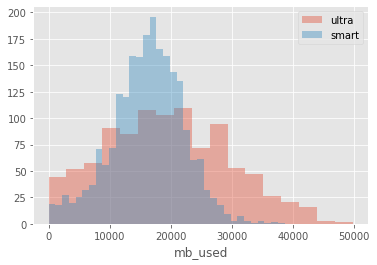

In [38]:
for tariff in ['ultra', 'smart']:
    sns.distplot(user_info.query('tariff == @tariff')['mb_used'], kde=False)
    plt.legend(['ultra', 'smart'])

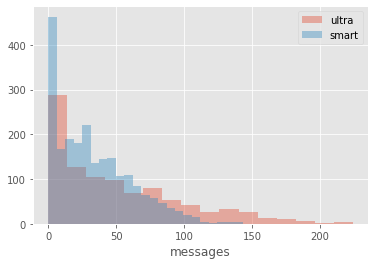

In [39]:
for tariff in ['ultra', 'smart']:
    sns.distplot(user_info.query('tariff == @tariff')['messages'], kde=False, label=tariff)
    plt.legend(['ultra', 'smart'])

На гистограммах хорошо видна разница в дисперсии - у пользователей тарифа «Ультра» она больше, чем у пользователей тарифа «Смарт». Интересно, что по всем параметрам мода тарифа «Смарт» явно выражена.

# Проверка гипотез

H₀ - средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

H₁ - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

α = 5%

In [40]:
ultra = user_info.query('tariff == "ultra"')['revenue']
smart = user_info.query('tariff == "smart"')['revenue']

alpha = .05

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


In [41]:
user_info.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,1038.0
ultra,1950.0


Выручка от пользователей тарифа «Ультра» в два раза превышает выручку от пользователей тарифа «Смарт».
Пользователи тарифа «Смарт» в среднем переплачивают в два раза из-за нехватки объема услуг по тарифу.

Проверим следующую гипотезу:

H₀ - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

H₁ - средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

α = 5%

In [44]:
moscow = user_info.query('city == "Москва"')['revenue']
regions = user_info.query('city != "Москва"')['revenue']

alpha = .05

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


In [45]:
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
user_info['region'] = user_info['city'].apply(det_region)
user_info.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1587.0
Москва,1750.0


Cредняя выручка от пользователей из Москвы и регионов примерно равна.

# Вывод

По результатам статистического анализа можно сделать вывод, что выручка компании от тарифа «Смарт» в два раза меньше, чем от тарифа «Ультра» - 1038 рублей и 1950 рублей в среднем соответственно. 

Cредняя выручка от пользователей из Москвы и регионов примерно равна - 1587 рублей для пользователей из регионов и 1750 рублей для пользователей из Москвы.

Приходим к выводу, что доходы компании от пользователей тарифа «Ультра» в два раза превышают доходы от пользователей тарифа «Смарт». Следовательно, для оператора лучше тариф «Ультра» - он приносит компании больше денег.